## Generative Adversarial Network
___
#### Description:
This GAN is fed images from the MNIST dataset to generate new images that resemble those from the dataset. It works by having a generator network and a discriminator network compete with one another. The generator is tasked to generate new images and it is the discriminators job to tell if the generated image is fake or real.
___
#### Dataset:

The MNIST dataset of handwritten numbers is used.
___
#### References:
https://deeplearning4j.org/generative-adversarial-network

https://github.com/soumith/ganhacks

In [8]:
!git clone https://github.com/chuiboy/Generative_Adversarial_Networks.git

Cloning into 'Generative_Adversarial_Networks'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (12/12), done.


In [9]:
cd Generative_Adversarial_Networks/

/content/Generative_Adversarial_Networks


In [0]:
# Import dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU

%matplotlib inline

In [11]:
# Import the dataset
from tensorflow.examples.tutorials.mnist import input_data

# Read the dataset
dataset = input_data.read_data_sets('../Datasets/MNIST/')

# Printing the dataset shape
print('X train:', dataset.train.images.shape)
print('X test:', dataset.test.images.shape)
print('y train:', dataset.train.labels.shape)
print('y test:', dataset.test.labels.shape)

# NOTE: Pixel values have already been preprocessed to lie between 0 and 1

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../Datasets/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../Datasets/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../Datasets/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../Datasets/MNIST/t10k-labels-idx1-ubyte.gz
X train: (55000, 784)
X test: (10000, 784)
y train: (55000,)
y test: (10000,)


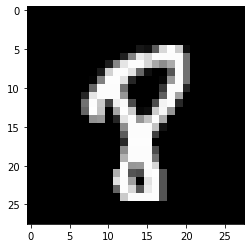

In [12]:
# Display a random training example
rand_idx = np.random.randint(dataset.train.num_examples)
plt.imshow(dataset.train.images[rand_idx].reshape(28, 28), cmap='gray')

In [0]:
# Functions to build models
def build_discriminator():
    X_input = Input((784,))
    out = Dense(128)(X_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(128)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(1, activation='sigmoid')(out)
    return Model(inputs=X_input, outputs=out)

def build_generator():
    z_input = Input((100,))
    out = Dense(128)(z_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(128)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(784, activation='tanh')(out)
    return Model(inputs=z_input, outputs=out)

def build_combined(generator, discriminator):
    discriminator.trainable = False
    z_input = Input((100,))
    out = discriminator(generator(z_input))
    return Model(inputs=z_input, outputs=out)

In [0]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='Adam')

# Build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', 
                  optimizer='Adam')

# Build and compile the combined network
combined = build_combined(generator, discriminator)
combined.compile(loss='binary_crossentropy', 
                 optimizer='Adam')


In [0]:
# Constants/Hyperparameters
epochs = 20 #original = 200
batch_size = 128

In [18]:
# Training
for epoch in range(epochs):
    
    num_batches = dataset.train.num_examples // batch_size

    for i in range(num_batches):

        real_batch_images, _ = dataset.train.next_batch(batch_size)            
        real_batch_images = real_batch_images * 2 - 1 # make pixel values between (-1, 1)

        # Generate fake images
        z = np.random.normal(0, 1, size=(batch_size, 100))       
        fake_batch_images = generator.predict(z)
        
        # Train discriminator and get loss
        D_real_loss = discriminator.train_on_batch(real_batch_images, np.random.uniform(0.7, 1.2, len(real_batch_images)))
        D_fake_loss = discriminator.train_on_batch(fake_batch_images, np.random.uniform(0.0, 0.3, len(fake_batch_images)))
        D_loss = D_real_loss + D_fake_loss

        # Train generator and get loss
        G_loss = combined.train_on_batch(z, np.random.uniform(0.7, 1.2, len(real_batch_images)))


    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print('Epoch {}:\tD_loss={},\tG_loss={}'.format(epoch, D_loss, G_loss))    
        
        # Save generated images every 10 epochs
        sample_z = np.random.normal(0, 1, size=(25, 100))
        gen_sample = generator.predict(sample_z)
        gen_sample = 0.5 * gen_sample + 0.5 # make pixel values between (0, 1)

        fig, ax = plt.subplots(5, 5)
        count = 0
        for i in range(5):
            for j in range(5):
                ax[i, j].imshow(gen_sample[count].reshape(28,28), cmap='gray')
                ax[i, j].axis('off')
                count += 1
        fig.savefig('images/epoch_%d.png' % epoch)
        plt.close()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0:	D_loss=0.962188720703125,	G_loss=1.5345064401626587
Epoch 10:	D_loss=1.0409237146377563,	G_loss=1.3130786418914795
